**Full Name:** Javad Hezareh

**Student Number:** 98101074


# Denoising Autoencoder
In this notebook, you are going to build and train a denoising autoencoder. The purpose of an autoencoder, a form of neural network, is to develop codings for data. 

An autoencoder has two parts: an encoder and a decoder. The encoder modifies the input data and produces a representation for the input in a smaller dimension, and the decoding function reconstructs the input data from the encoded representation. 

A denoising autoencoder is an autoencoder that gets noisy data as input and tries to produce the denoised output for that input.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from skimage.util import random_noise
from torch.utils.data import DataLoader

**For this question, it's highly recommended to use a CUDA-enabled environment.**
We'll check for the availability of GPU and set `device` accordingly.

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
device

device(type='cuda')

## Preparing the data
You'll use [Fashion MNIST](https://en.wikipedia.org/wiki/Fashion_MNIST) dataset to train your DAE.

100%|██████████| 26421880/26421880 [00:02<00:00, 11529568.83it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210764.56it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3895032.86it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14799367.37it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



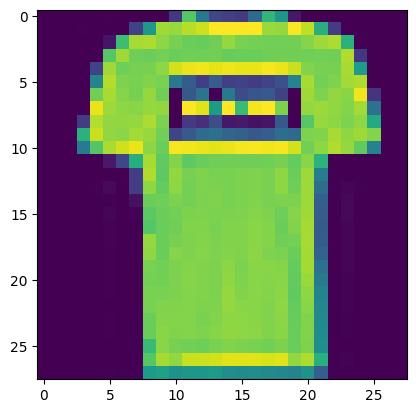

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [3]:
fm_train_set = datasets.FashionMNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
fm_test_set = datasets.FashionMNIST(root='./', train=False, download=True, transform=transforms.ToTensor())

# For both the `fm_train_set` and `fm_test_set` only keep the 
# images and leave out the labels.
# Also, normalize the values to be between [0, 1].
##############################
# Your code goes here (5 points)
train_imgs = fm_train_set.data / 255
test_imgs = fm_test_set.data / 255
##############################

plt.imshow(train_imgs[1].unsqueeze(0).permute(1, 2, 0))
plt.show()
print(train_imgs.shape, test_imgs.shape)

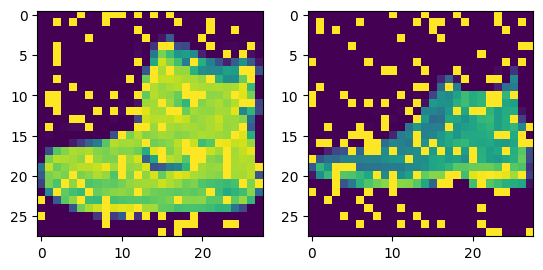

In [4]:
# For each image in our training and test sets,
# create a noisy version of the image.
# We'll use these noisy images as input data for the
# dataset we're going to create. The labels of this dataset
# would be the original images.
##############################
# Your code goes here (10 points)
noisy_train_imgs = torch.tensor(random_noise(train_imgs, mode='salt', amount=0.15))
noisy_test_imgs = torch.tensor(random_noise(test_imgs, mode='salt', amount=0.15))
##############################
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(noisy_train_imgs[0])
f.add_subplot(1, 2, 2)
plt.imshow(noisy_test_imgs[0])
plt.show()

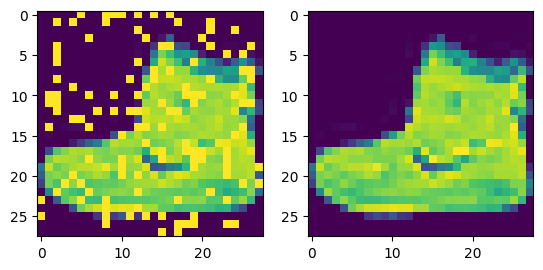

In [5]:
# Now we want to construct our new training and test sets.
# To do so, you'll use the noisy images you've created for each set
# as input for the new dataset and the original Fashion MNIST images as labels.

# Construct `training_set` (data, label) pairs.
##############################
# Your code goes here (10 points)
train_set = list(zip(noisy_train_imgs, train_imgs))
##############################

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(train_set[0][0]) 
f.add_subplot(1, 2, 2)
plt.imshow(train_set[0][1])
plt.show()

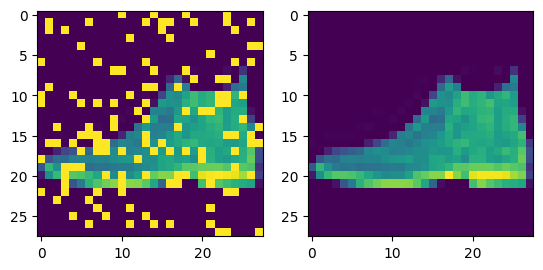

In [6]:
# Construct `test_set` (data, label) pairs.
##############################
# Your code goes here (5 points)
test_set = list(zip(noisy_test_imgs, test_imgs))
##############################

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(test_set[0][0]) 
f.add_subplot(1, 2, 2)
plt.imshow(test_set[0][1])
plt.show()

In [7]:
# Finally, create DataLoaders for the datasets.
# Use a batch size of 128 and enable shuffling.
##############################
# Your code goes here (5 points)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=False)
##############################

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7ff877a58310>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff877a58520>)

## Creating the Model


In this part, you're going to create the DAE model.

In [8]:
# The encoder takes the input and outputs the `encoded representation`.
# Create the encoder using nn.Sequential (You can use the architecture 
# shown in this cell's output).
# Use Conv2d layers followed by ReLU.
# After conv2d layers, flatten the data and use linear layers to
# smoothly transform the output from conv2d layers into the encoded space.
# Set the encoded space dimensions to 10 * 1.
##############################
# Your code goes here (15 points)
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=(2, 2), padding=(1, 1)),  #B  8   14  14
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, stride=(2, 2), padding=(1, 1)), #B  16  7   7
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=(2, 2)),                #B  32  3   3
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(288, 128),                                #B  128
            nn.ReLU(),
            nn.Linear(128, 64),                                 #B  64
            nn.ReLU(),
            nn.Linear(64, 10)                                   #B  10
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)          #B  1   28  28
        return self.f(x)

encoder = Encoder().to(device)
encoder
##############################

Encoder(
  (f): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=288, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=64, bias=True)
    (12): ReLU()
    (13): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [9]:
# The decoder takes the encoded data generated by the encoder
# and outputs the original input.
# Create the decoder using nn.Sequential.
# Reverse the operations used in encoder.
##############################
# Your code goes here (15 points)
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 288),        #B  288
            nn.ReLU()
        )
        self.convtranspose = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2),                                #B  16  7   7
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),    #B  8   14  14
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),     #B  8   28  28
        )
    
    def forward(self, x):
        b = x.shape[0]
        out = self.linear(x)
        out = torch.reshape(out, (b, 32, 3, 3))
        return self.convtranspose(out)

decoder = Decoder().to(device)
decoder
##############################

Decoder(
  (linear): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=288, bias=True)
    (5): ReLU()
  )
  (convtranspose): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

Now we can construct the DAE by sequentially connecting the `encoder` and `decoder` networks.

In [10]:
DAE = nn.Sequential(encoder, decoder).to(device=device)

## Training the DAE

### Visualizing the Latent Space

During the training, we intend to visualize the *encoded representations* learned by the DAE every 10 epochs. You are going to use T-SNE for this purpose. In order to do so, you have to pass the selected samples to the encoder and retrieve the encoded vectors. Then you can visualize these vectors on a plane and colorize the points according to the class of object each represent.

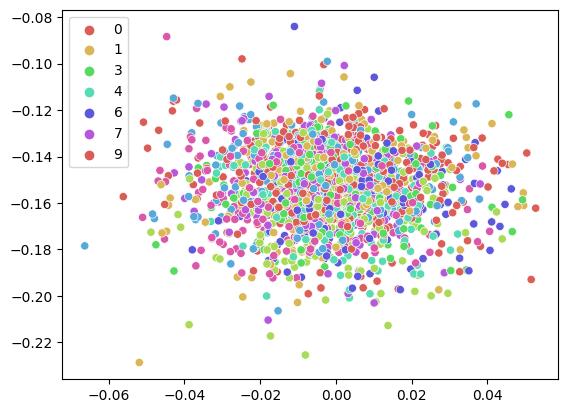

In [11]:
from sklearn.manifold import TSNE

def visualize():
    # Plot the encoded representations of the first 2000
    # images from `fm_train_set` on a plane.
    # You must first pass the images to
    # the encoder to get the encoded vectors, and then you
    # must transform these vectors to 2D space using TSNE
    # and plot the points.
    ##############################
    # Your code goes here (15 points)
    data = train_imgs.data[0:2000]
    labels = fm_train_set.targets[0:2000]
    with torch.no_grad():
        encodings = encoder(data.to(device)).cpu().numpy()

    space_2d = TSNE(n_components=2).fit_transform(encodings)

    sns.scatterplot(x=encodings[:, 0], y=encodings[:, 1], hue=labels, palette='hls')
    plt.show()
    ##############################

# Testing the function
visualize()

In [12]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # Compute the output.
            # Use GPU for your data if possible.
            ##############################
            # Your code goes here (5 points)
            optimizer.zero_grad()
            imgs = imgs.to(device)
            labels = labels.to(device)

            output = model(imgs)
            ##############################

            # Using `loss_fn` and `optimizer`, compute the loss and do the backprop step.
            ##############################
            # Your code goes here (5 points)
            labels = labels.unsqueeze(1)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item() * len(labels)
            ##############################
            
        print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))
        # Every 10 epochs, we visualize the encoded representations.
        if epoch % 10 == 0:
          visualize()

Epoch 1, Training loss 6.635088183478252
Epoch 2, Training loss 3.4719486905059327
Epoch 3, Training loss 3.139426626122074
Epoch 4, Training loss 2.952123568002095
Epoch 5, Training loss 2.836069026100102
Epoch 6, Training loss 2.7529239941761694
Epoch 7, Training loss 2.683238447729204
Epoch 8, Training loss 2.638445170703473
Epoch 9, Training loss 2.5735615635477402
Epoch 10, Training loss 2.5339114293614937


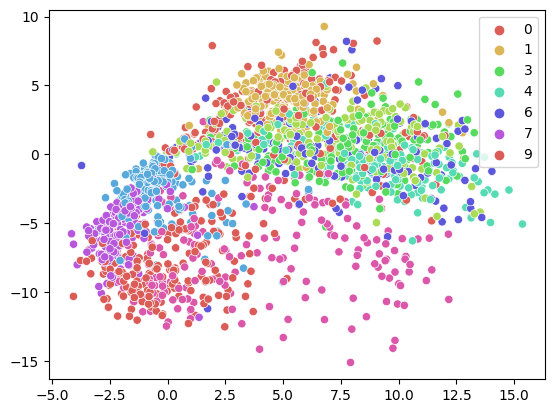

Epoch 11, Training loss 2.4817066402323467
Epoch 12, Training loss 2.4431961202926473
Epoch 13, Training loss 2.41941989853438
Epoch 14, Training loss 2.3856511771806015
Epoch 15, Training loss 2.3426839179321646
Epoch 16, Training loss 2.3033180362634313
Epoch 17, Training loss 2.281668496538581
Epoch 18, Training loss 2.260242275973119
Epoch 19, Training loss 2.212475265775408
Epoch 20, Training loss 2.2049059105326116


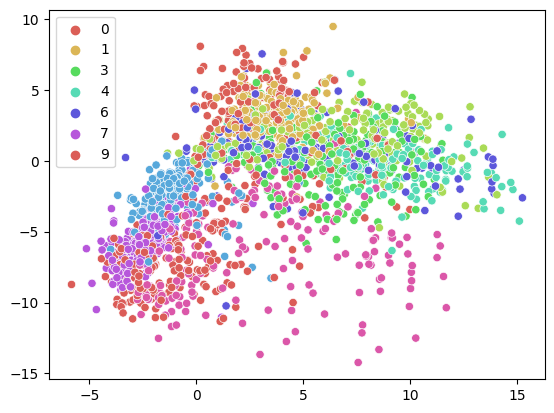

Epoch 21, Training loss 2.178729611292068
Epoch 22, Training loss 2.1619280760984685
Epoch 23, Training loss 2.133109550104975
Epoch 24, Training loss 2.1270404493630823
Epoch 25, Training loss 2.1062059158455333
Epoch 26, Training loss 2.0878117060356303
Epoch 27, Training loss 2.0809013124213798
Epoch 28, Training loss 2.0520211509041695
Epoch 29, Training loss 2.05357244922154
Epoch 30, Training loss 2.019744205957791


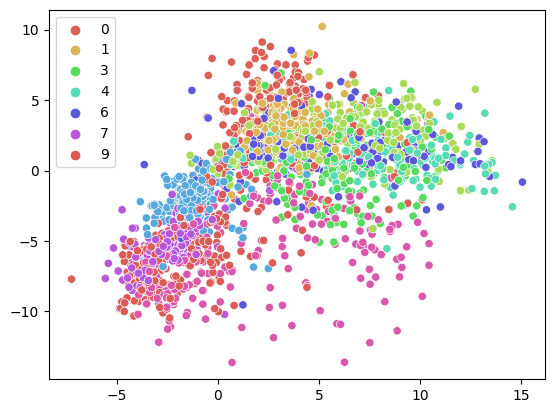

Epoch 31, Training loss 2.0065536482501893
Epoch 32, Training loss 2.0226588019175824
Epoch 33, Training loss 1.9989889265377638
Epoch 34, Training loss 1.9790191701226143
Epoch 35, Training loss 1.9751331151675569
Epoch 36, Training loss 1.9522145926825274
Epoch 37, Training loss 1.9475625694941865
Epoch 38, Training loss 1.938055910154192
Epoch 39, Training loss 1.934641525435295
Epoch 40, Training loss 1.9227916348590526


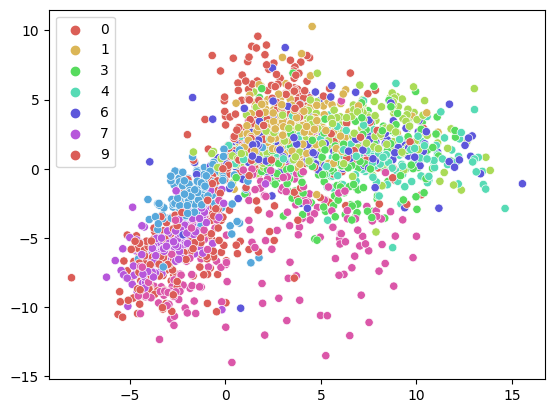

Epoch 41, Training loss 1.9277750000135223
Epoch 42, Training loss 1.9053499532788039
Epoch 43, Training loss 1.9065934580399284
Epoch 44, Training loss 1.9008552606171891
Epoch 45, Training loss 1.8860941887028944
Epoch 46, Training loss 1.8821027975346742
Epoch 47, Training loss 1.8691834053759382
Epoch 48, Training loss 1.876501032792683
Epoch 49, Training loss 1.8692799162254659
Epoch 50, Training loss 1.8548886537043525


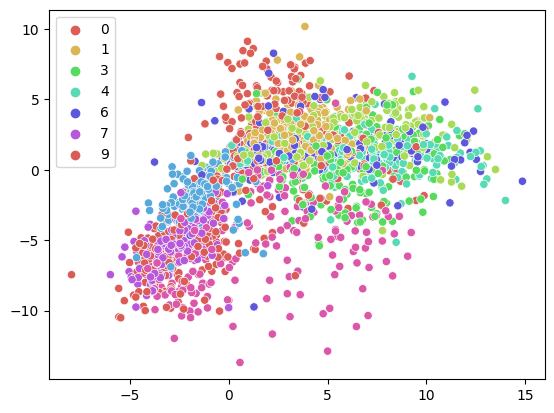

In [13]:
epochs = 50
# Train the DAE. use MSE as the loss function and 
# use Adam for the optimizer. Set the learning rate to 1e-3.
##############################
# Your code goes here (5 points)
optimizer = optim.Adam(DAE.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train(
    epochs,
    optimizer,
    DAE,
    loss_fn,
    train_loader
)
##############################

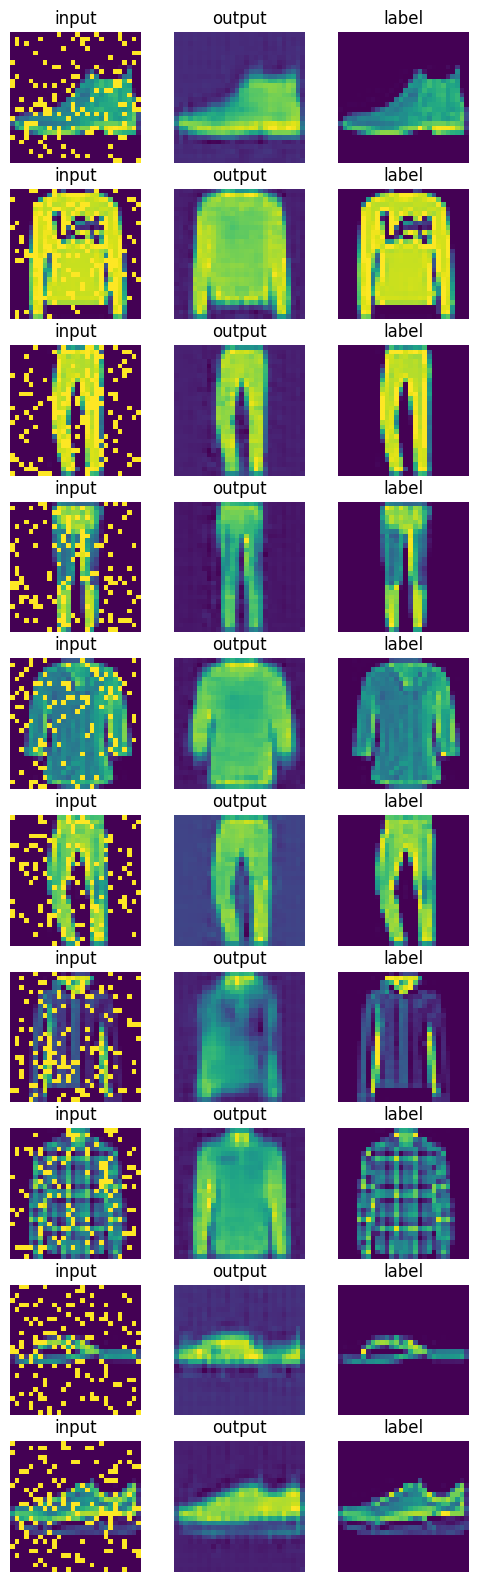

In [14]:
# Use 10 examples from the testing set to evaluate the 
# DAE's outputs visually.
##############################
# Your code goes here (5 points)
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = DAE(imgs)
        break

imgs = imgs.squeeze(1).cpu().numpy()
labels = labels.cpu().numpy()
outputs = outputs.squeeze(1).cpu().numpy()

fig, axis = plt.subplots(10, 3, figsize=(2*3, 2*10))

for i in range(10):
    axis[i, 0].imshow(imgs[i, :, :])
    axis[i, 1].imshow(outputs[i, :, :])
    axis[i, 2].imshow(labels[i, :, :])
    axis[i, 0].axis('off')
    axis[i, 1].axis('off')
    axis[i, 2].axis('off')
    axis[i, 0].set_title('input')
    axis[i, 1].set_title('output')
    axis[i, 2].set_title('label')
##############################